In [ ]:
# LunarLander debug note
# Initially, used the same code I used for cartpole.
# Would not train, so printed out the probs. When the model is first made, it is fairly distributed like this [[0.2660, 0.2257, 0.2731, 0.2352]]. However, after training for 1000 steps,
# it converges to a certain action like this - tensor([[9.9943e-01, 4.8898e-04, 7.9276e-05, 4.1656e-08]]
# Applied entropy for more exploration. Didn't work
# Found much larger absolute value of advantages, returns, compared to cartpole. Especially, when terminated, the return is -100 which is the dominant cause for the returns.
# Normalizing advantage solved the problem above. Now it doesn't fixate in a certain action.
# Then, action_probability turned into a somewhat uniform distribution. Therefore, printed out the losses.
# Actor loss:  tensor(-1.9073e-08, device='cuda:0', grad_fn=<NegBackward0>) Critic loss:  tensor(15.9172, device='cuda:0', grad_fn=<MseLossBackward0>)
# Entropy:  tensor(1.3784, device='cuda:0', grad_fn=<MeanBackward0>)
# Found out that Actor loss is extremely small. Therefore, actor layer was barely getting updated.
# Reason: log prob is pretty much uniform when model is initialized and the advantage is normalized with mean 0. We calculate actor_loss = (advantages * log_probs).mean()
# This converges to the mean of the normal distribution (since log_probs is uniform), and therefore to 0.
# Try with normalizing the n-step rewards instead of the advantage.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: 

In [ ]:
!pip install gymnasium
!pip install pygame
!pip install wheel setuptools pip --upgrade
!pip install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 89.1 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 50.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'box2d-py' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'box2d-py'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class ActorCritic(nn.Module):

    # Increased hidden dim to (128, 128) compared to cartpole as the input_dim is more complex
    def __init__(self, input_dim, output_dim, hidden_dims=(128, 128)):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU()
        )
        self.actor_layer = nn.Linear(hidden_dims[1], output_dim)
        self.critic_layer = nn.Linear(hidden_dims[1], 1)

    def forward(self, x):
        x = self.net(x)
        action_probs = F.softmax(self.actor_layer(x), dim=-1)
        value = self.critic_layer(x)
        return action_probs, value



In [ ]:
from tqdm import tqdm

class A2CAgent:
    def __init__(self, env, num_episodes=1000, max_steps=500, gamma=0.99, lr=1e-3, num_steps = 5):
        self.env = env
        self.num_episodes = num_episodes
        self.max_steps = max_steps
        self.gamma = gamma
        self.lr = lr
        self.num_steps = num_steps
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = ActorCritic(env.observation_space.shape[0], env.action_space.n).to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.loss = nn.MSELoss()

    # choosing action from policy's probability distribution
    def choose_action(self, state):
        probs, _ = self.policy_net(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action

    # computing the gamma decaying rewards
    def compute_return(self, rewards):
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + self.gamma * R
            returns.insert(0, R)
        return returns

    # computing the n step rewards
    def compute_n_step_returns(self, rewards, next_value):
        # bootstraps the future reward using value estimate
        R = next_value
        returns = []
        for r in reversed(rewards):
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = torch.stack(returns)
        if returns.numel() > 1:
            return (returns - returns.mean()) / (returns.std() + 1e-8)
        else:
            return returns * 0

    def train(self):
        episode_rewards = []

        for episode in tqdm(range(self.num_episodes)):
            state, _ = self.env.reset()
            episode_reward = 0
            values = []
            rewards = []
            log_probs = []
            steps = 0
            done = False

            while not done and steps < self.max_steps:
                steps += 1
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
                action_probs, value = self.policy_net(state_tensor)
                action_dist = torch.distributions.Categorical(action_probs)
                action = action_dist.sample()
                log_prob = action_dist.log_prob(action)

                next_state, reward, terminated, truncated, _ = self.env.step(action.item())
                done = terminated or truncated

                # saves the values, rewards, log_probs which are used to calculate the n_step returns, actor loss, and critic loss
                values.append(value.squeeze())
                rewards.append(reward)
                log_probs.append(log_prob)

                episode_reward += reward
                state = next_state

                # every n steps, calculate losses, update the actor & critic, then refresh the saved lists
                if (steps % self.num_steps == 0) or done:
                    _, next_value = self.policy_net(torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(self.device))
                    next_value = next_value.squeeze()
                    # BUG ALERT
                    # MUST MULTIPLY (1 - done) to next_value to mask the bootstrapped next_value when the game is over. CRITICAL BUG THAT TOOK HOURS TO FIND
                    returns = self.compute_n_step_returns(rewards, next_value * (1 - done))
                    values = torch.stack(values)
                    log_probs = torch.stack(log_probs)
                    advantages = returns - values

                    # normalize advantages
                    # if advantages.numel() > 1:
                    #     advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
                    # else:
                    #     advantages = advantages * 0  # or skip the update

                    # calculate actor_loss by multiplying log probabilities to advantages. This will decrease the action probability of negative advantages, and vice-versa
                    actor_loss = - (log_probs * advantages.detach()).mean()
                    # updates the critic to find better estimate of values that matches the n-step reward
                    critic_loss = self.loss(returns, values)

                    # penalize using entropy to encourage exploration
                    entropy = action_dist.entropy().mean()
                    # if episode % 50 == 0:
                      # print(steps, "RETURN: ", returns, "VALUE: ", values, "ADVANTAGE: ", advantages, log_probs)
                      # print("log prob: ", log_probs, "advantages: ", advantages)
                      # print("Actor loss: ", actor_loss, "Critic loss: ", critic_loss, "Entropy: ", entropy)
                    loss = 5 * actor_loss + 0.4 * critic_loss - 0.03 * entropy
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                    values = []
                    rewards = []
                    log_probs = []

            episode_rewards.append(episode_reward)

        self.env.close()
        return np.array(episode_rewards)


In [ ]:
import gymnasium as gym

env = gym.make('LunarLander-v3')
num_episodes = 5000
max_steps = 1000
lr = 3e-3


a2c_model_ll =  A2CAgent(env, num_episodes=num_episodes, max_steps=max_steps, lr=lr, num_steps = 8)

state, _ = env.reset()
state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(a2c_model_ll.device)
action_probs, _ = a2c_model_ll.policy_net(state)
print(action_probs)

rewards = a2c_model_ll.train()


tensor([[0.2350, 0.2394, 0.2530, 0.2726]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


100%|██████████| 5000/5000 [20:12<00:00,  4.12it/s]


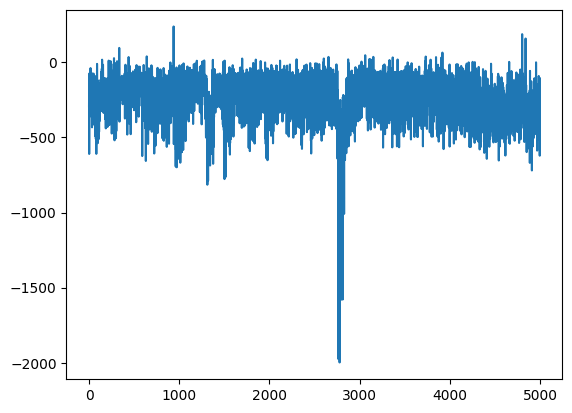

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(rewards)), rewards)
plt.show()

In [ ]:
import gymnasium as gym
import torch
import numpy as np
from gymnasium.wrappers import RecordVideo
import os

# Create folder to save the video
video_folder = "./video"
os.makedirs(video_folder, exist_ok=True)

# Wrap the environment with RecordVideo
env = gym.make('LunarLander-v3', render_mode='rgb_array')
env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda e: True)

num_episodes = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

episode_rewards = []

for i in range(num_episodes):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    episode_reward = 0
    done = False

    while not done:
        with torch.no_grad():
            action_probs, _ = a2c_model_ll.policy_net(state)
            # action_dist = torch.distributions.Categorical(action_probs)
            # action = action_dist.sample().item()
            action = torch.argmax(action_probs, dim=1).item()
            print(action)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward

        print(action_probs)
        print(reward)

        state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)

    episode_rewards.append(episode_reward)
    print(f"Episode {i+1} Reward: {episode_reward}")

env.close()

episode_rewards = np.array(episode_rewards)
print(f"Average Reward over {num_episodes} episodes: {np.mean(episode_rewards)}")


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


2
tensor([[0.1932, 0.2375, 0.3031, 0.2662]], device='cuda:0')
-4.960227704406907
2
tensor([[0.1932, 0.2375, 0.3031, 0.2662]], device='cuda:0')
-4.818749288654163
2
tensor([[0.1932, 0.2375, 0.3031, 0.2662]], device='cuda:0')
-4.034316882469073
2
tensor([[0.1932, 0.2375, 0.3031, 0.2662]], device='cuda:0')
-3.417196199870591
2
tensor([[0.1932, 0.2375, 0.3031, 0.2662]], device='cuda:0')
-3.477283278128982
2
tensor([[0.1932, 0.2375, 0.3031, 0.2662]], device='cuda:0')
-5.4086854358804315
2
tensor([[0.1932, 0.2375, 0.3031, 0.2662]], device='cuda:0')
-3.688781876786538
2
tensor([[0.1932, 0.2375, 0.3031, 0.2662]], device='cuda:0')
-3.619390603527722
2
tensor([[0.1932, 0.2375, 0.3031, 0.2662]], device='cuda:0')
-2.3644605004168566
2
tensor([[0.1932, 0.2375, 0.3031, 0.2662]], device='cuda:0')
-3.294233845588468
2
tensor([[0.1932, 0.2375, 0.3031, 0.2662]], device='cuda:0')
-4.873710746941401
2
tensor([[0.1932, 0.2375, 0.3031, 0.2662]], device='cuda:0')
-3.6845837978360008
2
tensor([[0.1932, 0.2375

In [ ]:
import gymnasium as gym

env = gym.make('CartPole-v1')
num_episodes = 10
max_steps = 500
lr = 1e-3

#num_steps = max_steps make it Monte-Carlo
a2c_model_mc =  A2CAgent(env, num_episodes=num_episodes, max_steps=max_steps, lr=lr, num_steps = max_steps)

rewards = a2c_model_mc.train()

100%|██████████| 10/10 [00:00<00:00, 17.79it/s]
